# How to use iso-probabilistic transformations to obtain weather-corrleated spot markets with a desired distribution

In [5]:
import numpy as np
from numpy import newaxis as na
import pandas as pd
import scipy
from statsmodels.distributions.empirical_distribution import ECDF, monotone_fn_inverter
from hydesign.weather import isoprob_transfrom
from hydesign.examples import examples_filepath

In [ ]:
inputs = pd.read_csv(examples_filepath+'Europe/GWA2/input_ts_Denmark_good_solar.csv',
                    index_col=0, parse_dates = True)
inputs

## 1. Sample a target distrubtion, the number of samples can be different between input data and desired distribution

In [ ]:
#y_desired = np.random.normal(size=int(1e6)) * 5 + 35

y_desired = np.random.weibull(a=2, size=int(1e6)) * 25 + 18

In [ ]:
y_ISO = isoprob_transfrom(y_input=inputs.Price.values, y_desired=y_desired)

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
inputs.Price.hist(bins=100, histtype='step', density=True, label = 'SM input')
plt.hist(y_desired,bins=100, histtype='step', density=True, label = 'Desired PDF')
plt.hist(y_ISO,bins=100, histtype='step', density=True, label = 'SM ISO transformed')
plt.xlabel('SM [EUR/MW.h]')
plt.ylabel('PDF(SM)')
plt.legend()
print()

In [ ]:
inputs['SM_ISO'] = y_ISO

In [ ]:
inputs.loc[:,['Price','SM_ISO']].describe()

In [ ]:
inputs.Price.plot(label = 'SM input')
inputs.SM_ISO.plot(alpha=0.5, label = 'SM ISO transformed')
plt.ylabel('SM [EUR/MW.h]')
plt.xlabel('time')
plt.legend()
print()

In [ ]:
inputs.loc[:,['WS_100','Price','SM_ISO']].corr()

In [6]:
inputs['ws_bin'] = pd.cut(inputs.WS_100, bins=np.arange(0,20,1))

inputs_grp = inputs.groupby('ws_bin').mean()

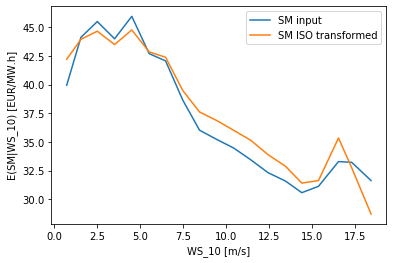

In [172]:

plt.plot(inputs_grp.WS_100, inputs_grp.Price, label = 'SM input')
plt.plot(inputs_grp.WS_100, inputs_grp.SM_ISO, label = 'SM ISO transformed')
plt.legend()

plt.ylabel(r'E(SM|WS_10) [EUR/MW.h]')
plt.xlabel('WS_10 [m/s]')

print()

In [ ]:
import scipy.stats as st
def kde_plot(
    x,y,
    ax,
    c='k',
    levels = [1e-5, 5e-5, 1e-4, 5e-4],
    fmt = '%1.0e',
    label = None
    ):
    xmin = np.min(x) 
    xmax = np.max(x)
    ymin = np.min(y) 
    ymax = np.max(y)

    # Peform the kernel density estimate
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    # Contour plot
    cset = ax.contour(xx, yy, f, levels=levels, colors=c)
    if label != None:
        cset.collections[0].set_label(label) 
    # iso-prob labels on lines
    ax.clabel(cset, inline=1, fontsize=10, fmt = fmt)
    

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
kde_plot(x=inputs.WS_100, y=inputs.Price, ax=ax, levels = [1e-5, 1e-4, 1e-3], c='C0', label='SM ISO transformed')
kde_plot(x=inputs.WS_100, y=inputs.SM_ISO, ax=ax, levels = [1e-5, 1e-4, 1e-3], c='C1', label='SM input')
plt.legend()
plt.title('Iso probability countours')
plt.ylabel('SM [EUR/MW.h]')
plt.xlabel('WS_10 [m/s]')    